# Numerical methods: Scipy

*Davide Gerosa (Milano-Bicocca)*

**Sources**: Michael Zingale at Stony Brook University: https://sbu-python-class.github.io

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

# Exercises

For the exam, please complete two of these exercise (don't pick both Q1 and Q2, too easy)

## Q1: Simple numerical integral

Numerical integration methods work differently depending on whether you have the analytic function available (in which case you can evaluate it freely at any point you please) or if it is sampled for you.

Consider the function $f(x) = e^{-x^2}$.  We want to integrate this from $[-5, 5]$.  The
analytic integral is not easily obtained.  Use `integrate.quad` to do the integration.

In [2]:
def func(x):
    return np.exp(-x**2)
    
real, err = scipy.integrate.quad(func, -5, 5)

Consider now that you have data that represents a function sampled a `N` points, but you don't know the analytic form of the function.  Here, we create the sampling from a uniform distribution

In [3]:
N = 32
x = np.linspace(-5, 5, N)
f = np.exp(-x**2)
f

array([1.38879439e-11, 3.15061953e-10, 5.80457065e-09, 8.68481106e-08,
       1.05527775e-06, 1.04133225e-05, 8.34503173e-05, 5.43103745e-04,
       2.87047478e-03, 1.23208538e-02, 4.29481052e-02, 1.21580337e-01,
       2.79510942e-01, 5.21855680e-01, 7.91258065e-01, 9.74320895e-01,
       9.74320895e-01, 7.91258065e-01, 5.21855680e-01, 2.79510942e-01,
       1.21580337e-01, 4.29481052e-02, 1.23208538e-02, 2.87047478e-03,
       5.43103745e-04, 8.34503173e-05, 1.04133225e-05, 1.05527775e-06,
       8.68481106e-08, 5.80457065e-09, 3.15061953e-10, 1.38879439e-11])

Compute the integral of this sampled function using Simpson's method (`integrate.simps`).  Now, vary the number of sample points (try 64, 128, ...) and see how the answer changes.  Simpson's method is 4-th order accurate, which means that the error should decrease by $2^4$ when we double the number of sample points

Make a plot of the error (compared to the quadrature result) vs. N

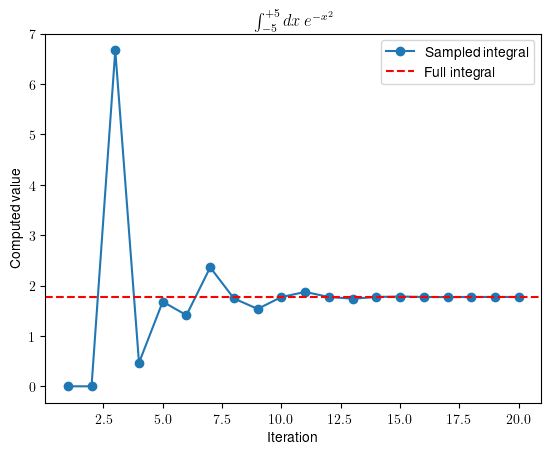

In [4]:
def simps(N):
    N = int(N)
    x = np.linspace(-5, 5, N)
    f = np.exp(-x**2)
    return scipy.integrate.simps(f, x)

x = np.linspace(1, 20, 20)
y = [simps(val) for val in x]

plt.ylabel("Computed value")
plt.xlabel("Iteration")
plt.title("$\int_{-5}^{+5}dx\,e^{-x^2}$")
plt.plot(x, y, label="Sampled integral", marker="o")
plt.axhline(real, linestyle="--", color="red", label="Full integral")
plt.legend()
plt.show()

## Q7: Noisy signal

A convolution is defined as:  

  \begin{equation}                                                                           
    (f \star g)(t) \equiv \int_{-\infty}^{\infty} f(\tau) g(t - \tau) d\tau                   
  \end{equation}                                                                             

  It is easy to compute this with FFTs, via the _convolution theorem_,                                                                        
  \begin{equation}                                         
    \mathcal{F}\{f \star g\} = \mathcal{F}\{f\} \, \mathcal{F}\{g\}                                          
  \end{equation}                                         
  That is: the Fourier transform of the convolution of $f$ and $g$ is simply
  the product of the individual transforms of $f$ and $g$.  This allows us
  to compute the convolution via multiplication in Fourier space and then take
  the inverse transform, $\mathcal{F}^{-1}\{\}$, to recover the convolution in real space:
  
  \begin{equation}
  f \star g = \mathcal{F}^{-1}\{ \mathcal{F}\{f\} \, \mathcal{F}\{g\}\}
  \end{equation}
  
A common use of a convolution is to smooth noisy data, for example by convolving noisy data with a Gaussian.  We'll do that here.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

Here's some noisy data we'll work with

In [6]:
def fdata(x, L):
    A = L/10.0
    return 2*np.sin(2*np.pi*x/L) + x*(L-x)**2/L**3 * np.cos(x) + \
           5*x*(L-x)/L**2 + A/2 + 0.1*A*np.sin(13*np.pi*x/L)

N = 2048
L = 50.0
x = np.linspace(0, L, N, endpoint=False)
orig = fdata(x, L)
noisy = orig + 0.5*np.random.randn(N)

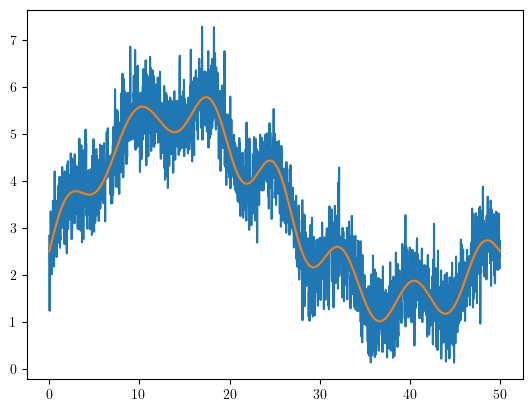

In [7]:
plt.plot(x, noisy)
plt.plot(x, orig)

SciPy provides a convolution function `scipy.signal.convolve()` that can do the convolution for us directly.  To smooth the data, we want to use a Gaussian, which can be produced by `scipy.signal.gaussian()`.

Convolve the noisy data with a Gaussian and plot the result together with the original data `orig`.  You'll need to play with the width of the Gaussian to get a nice smoothing.  You also will need to normalize the Gaussian so that it sums to 1, otherwise, your convolved data will be shifted verfically from the original function.

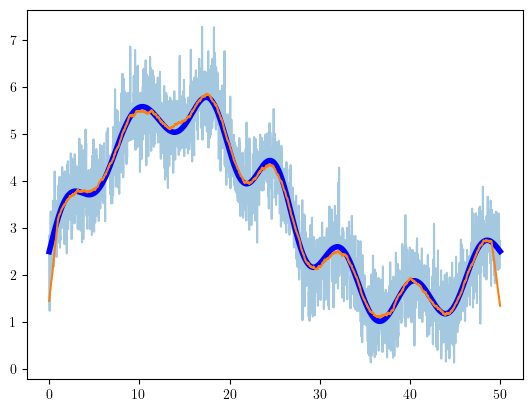

In [8]:
y = scipy.signal.convolve(noisy, scipy.signal.windows.gaussian(80, 6e2), mode="same")

plt.plot(x, noisy, alpha=0.4)
plt.plot(x, orig, color="blue", linewidth=4)
plt.plot(x, y/80, linewidth=1.5)

In [9]:
from functools import partial
from scipy.integrate import solve_ivp

def rhs(t, Y, q, omega_d, b):
    """ damped driven pendulum system derivatives.  Here, Y = (theta, omega) are
        the solution variables. """
    f = np.zeros_like(Y)
        
    f[0] = Y[1]
    f[1] = -q*Y[1] - np.sin(Y[0]) + b*np.cos(omega_d*t)

    return f

def restrict_theta(theta):
    """ convert theta to be restricted to lie between -pi and pi"""
    tnew = theta + np.pi
    tnew += -2.0*np.pi*np.floor(tnew/(2.0*np.pi))
    tnew -= np.pi
    return tnew

def int_pendulum(theta0, q, omega_d, b, tend, dt):
    """ integrate the pendulum and return solution with dt"""

    # points in time where we'll request the solution
    tpoints = np.arange(0.0, tend, dt)
    
    r = solve_ivp(partial(rhs, q=q, omega_d=omega_d, b=b),
                  [0.0, tend], [theta0, 0.0],
                  method='RK45', t_eval=tpoints)

    return r.t, r.y

The call below will give an undamped pendulum.  For a small amplitude, since we have $L = g$ in our pendulum, the period is simply $T = 2\pi$, and the frequency is $\nu_k = 1/(2\pi)$.  We plot things in terms of angular frequency, $\omega_k = 2\pi \nu_k$, so all the power will be at $\omega_k = 1$.

In [10]:
t, y = int_pendulum(np.radians(10), 0.0, 0.6666, 0.0, 200.0, 0.1)

Your task is to complete the power spectrum routine below to calculate the FFT of theta and plot it.  Experiment with the damping and driving parameters to see the complexity of the pendulum in frequency space when it becomes chaotic.  For reference, here's a plot of the solution theta

Text(0, 0.5, '$\\theta$')

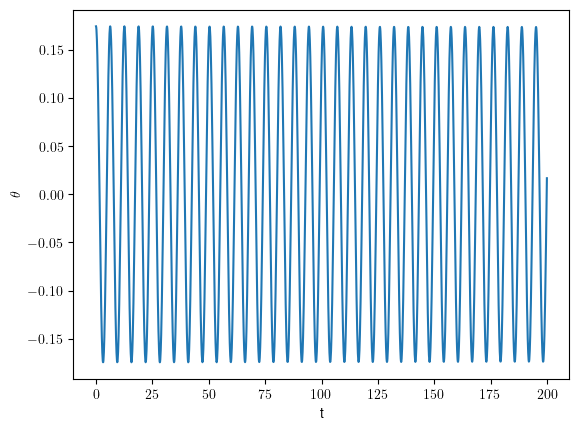

In [11]:
plt.plot(t, restrict_theta(y[0,:]))
plt.xlabel("t")
plt.ylabel(r"$\theta$")

In [12]:
def power_spectrum(t, theta0):
    """ return the power spectrum of theta.  For the frequency
        component, return it in terms of omega """

    theta = restrict_theta(theta0)
    
    # fill in the rest -- take the FFT of theta and return omega_k and 
    # the transform of theta
